In [1]:
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, applications
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

2023-01-03 21:31:28.955297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### so far, these are the pastries we have 50 pictures of --- all stored in the raw_data folder ###

available_pastries = [subdir for subdir in os.listdir('raw_data') if not subdir.startswith('.')]
available_pastries.sort()
available_pastries

['bolo_arroz', 'brigadeiro', 'ovos_moles', 'pastel_nata', 'pastel_tentugal']

In [3]:
### gets the minimum dimension from all images --- that will be the target_size ###

imgs = []
y = []
width_list = []
height_list = []

for pastry_name in available_pastries:
    for filename in os.scandir('raw_data/' + pastry_name):
        file_name, file_extension = os.path.splitext(filename.path)
        if filename.is_file() and file_extension == '.jpeg':

            # get image dimensions
            height, width = decode_jpeg(read_file(filename.path), 3).shape[:2]
            width_list.append(width)
            height_list.append(height)

# find smallest dimension from all files 
min_dim = min(min(height_list), min(width_list))

# give feedback
print('Minimum image height: ' +  str(min(height_list)))
print('Minimum image width: ' + str(min(width_list))) 
print('--> Target size: ' + str(min_dim)) 

2023-01-03 21:31:35.528390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Minimum image height: 156
Minimum image width: 200
--> Target size: 156


In [4]:
# Preprocessing using Keras ImageDataGenerator
# Using all available images to train (for now, just to make the model function)

train_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='raw_data', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10)

Found 250 images belonging to 5 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:
def plot_images(images_array):
    """
    Plots preprocessed images
    """
    
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

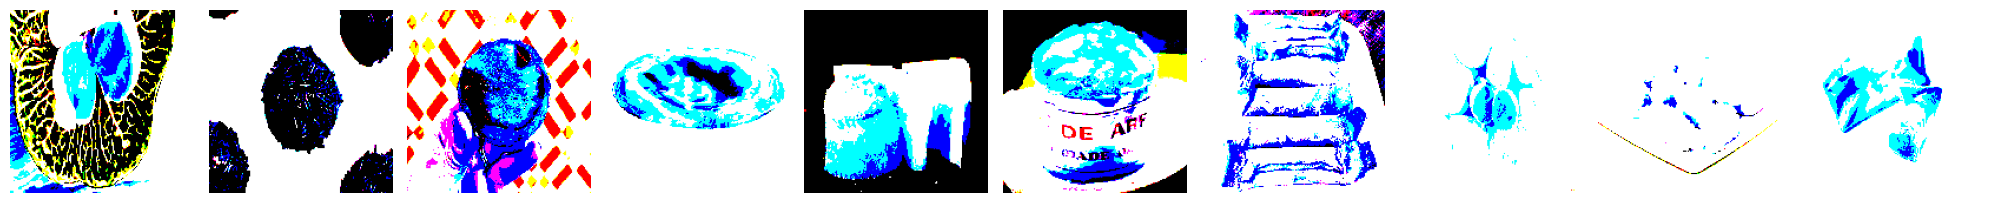

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [7]:
# Plot proprocessed images and corresponding labels

plot_images(imgs)
print(labels)

In [8]:
def initialize_model():
    
    model = Sequential()

    model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(min_dim, min_dim, 3)))
    model.add(layers.MaxPool2D(pool_size=(4,4)))
    
    model.add(layers.Conv2D(32, kernel_size=(3, 3)))
    model.add(layers.MaxPool2D(pool_size=(3,3)))
    
    model.add(layers.Conv2D(16, kernel_size=(3, 3)))
    model.add(layers.MaxPool2D())

    model.add(layers.Flatten())
    
    model.add(layers.Dense(10, activation='relu'))

    model.add(layers.Dense(len(available_pastries), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model  

In [9]:
X_train = imgs
y_train = labels

In [10]:
model = initialize_model()

es = EarlyStopping(patience=10)

history = model.fit(X_train, y_train,
                 epochs=100,
                 batch_size=32, 
                 verbose=1,
                 callbacks=[es],
                 validation_split=0.3)

Epoch 1/100
1/1 [==============================] - 1s 817ms/step - loss: 85.3158 - accuracy: 0.1429 - val_loss: 3.5527 - val_accuracy: 0.6667
Epoch 2/100
1/1 [==============================] - 0s 70ms/step - loss: 28.7334 - accuracy: 0.1429 - val_loss: 7.3791 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 70ms/step - loss: 19.0187 - accuracy: 0.2857 - val_loss: 2.8198 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 73ms/step - loss: 6.1192 - accuracy: 0.4286 - val_loss: 1.6100 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 68ms/step - loss: 1.1913 - accuracy: 0.5714 - val_loss: 1.6103 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 71ms/step - loss: 1.9646 - accuracy: 0.2857 - val_loss: 1.6106 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 69ms/step - loss: 1.5541 - accuracy: 0.2857 - val_loss: 2.0620 - val_accuracy: 0.0

In [11]:
test_batches = ImageDataGenerator(preprocessing_function=applications.vgg16.preprocess_input) \
    .flow_from_directory(directory='test_data', target_size=(min_dim, min_dim), classes=available_pastries, batch_size=10, shuffle=False)

Found 5 images belonging to 5 classes.


In [12]:
predictions = model.predict(test_batches)
predictions

1/1 [==============================] - 0s 281ms/step


array([[1.1564753e-04, 7.2290087e-01, 3.3487346e-15, 2.7491811e-01,
        2.0654106e-03],
       [1.0554949e-01, 1.2817998e-11, 4.4207055e-02, 8.5024345e-01,
        4.3307033e-18],
       [1.0786666e-02, 1.9457126e-02, 6.0393764e-03, 2.0585118e-02,
        9.4313174e-01],
       [8.6139876e-01, 4.7630467e-05, 2.9086506e-02, 1.0946705e-01,
        1.3663360e-11],
       [8.0319417e-01, 6.3254451e-04, 4.3363199e-02, 1.5281004e-01,
        1.0253373e-08]], dtype=float32)

In [13]:
for prediction in predictions:
    print(available_pastries[np.argmax(prediction)])

brigadeiro
pastel_nata
pastel_tentugal
bolo_arroz
bolo_arroz


In [14]:
imgs_test, labels_test = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


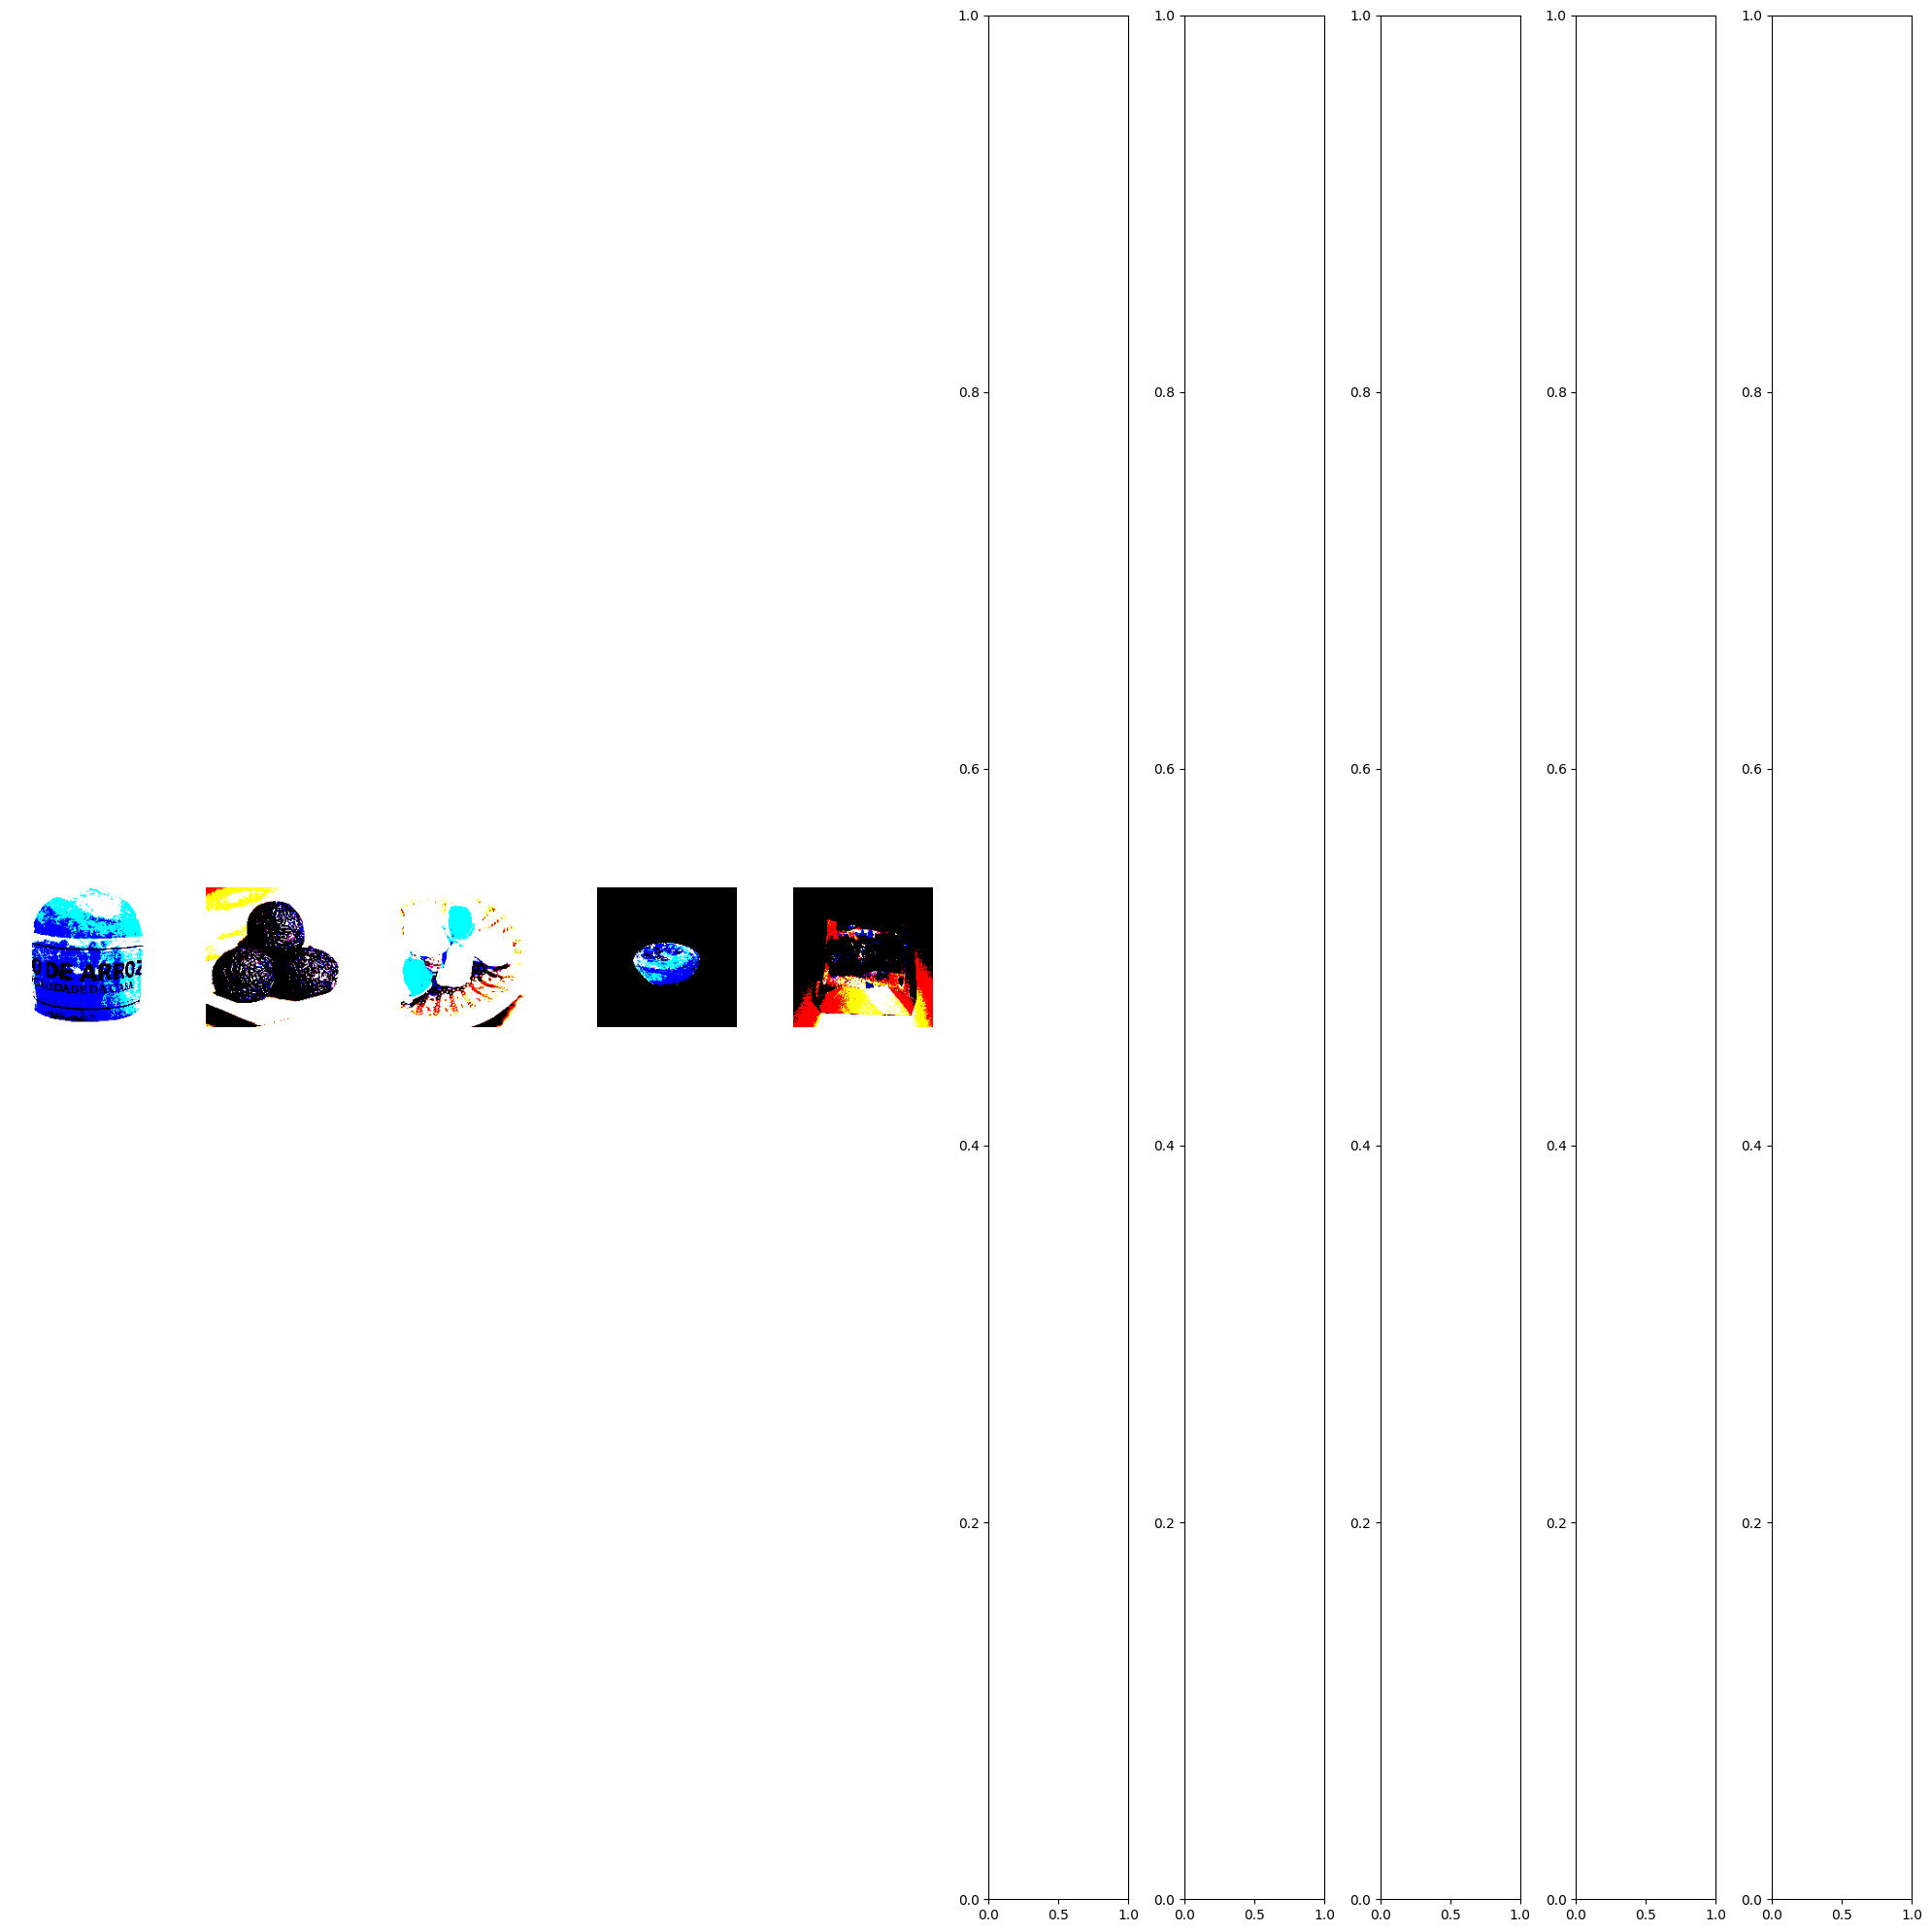

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [15]:
plot_images(imgs_test)
print(labels_test)

In [16]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

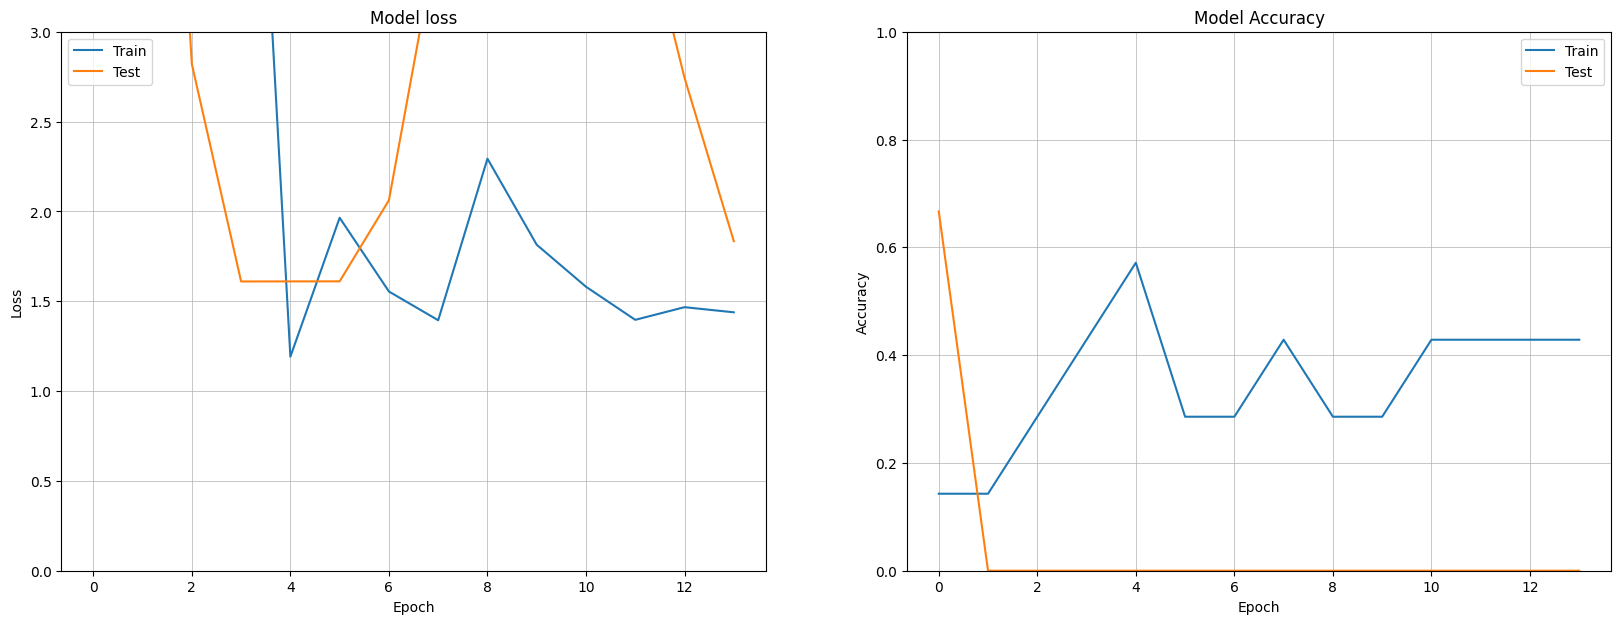

In [17]:
plot_loss_accuracy(history)